In [164]:
#load all packages
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_curve, auc
from keras import metrics
import keras.backend as K
from keras.utils import to_categorical, image_dataset_from_directory
import cv2
import glob
from tensorflow.python.client import device_lib
from sklearn.multiclass import OneVsRestClassifier


In [2]:
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#from tensorflow.python.client import device_lib 
#print(device_lib.list_local_devices())

In [3]:
train_images = [cv2.imread(file) for file in glob.glob("F:\\MRI_class\\data\\Alzheimer_Dataset2\\train\\NonDemented\\*.jpg")]

'''for t in range(0,len(train_images)):
    train_images[t] = (((train_images[t] - np.mean(train_images[t])) / np.std(train_images[t])))
    train_images[t] = np.clip(train_images[t], -1,1)
    train_images[t] = (train_images[t] + 1) / 2
'''
train_images = np.concatenate([image[:,:,:,np.newaxis] for image in train_images],axis=3)
train_images = np.moveaxis(train_images,3,0)
train_images = train_images[:,:,:,0]
nonD_train_images = train_images[:,:,:,np.newaxis]


In [4]:
idx = int(len(nonD_train_images)*0.2)
train_val = nonD_train_images[:idx]
nonD_train_images = nonD_train_images[idx:]



In [5]:
train_images = [cv2.imread(file) for file in glob.glob("F:\\MRI_class\\data\\Alzheimer_Dataset2\\train\\VeryMildDemented\\*.jpg")]

'''for t in range(0,len(train_images)):
    train_images[t] = (((train_images[t] - np.mean(train_images[t])) / np.std(train_images[t])))
    train_images[t] = np.clip(train_images[t], -1,1)
    train_images[t] = (train_images[t] + 1) / 2
   '''
train_images = np.concatenate([image[:,:,:,np.newaxis] for image in train_images],axis=3)
train_images = np.moveaxis(train_images,3,0)
train_images = train_images[:,:,:,0]
vmD_train_images = train_images[:,:,:,np.newaxis]


In [6]:
idx = int(len(vmD_train_images)*0.2)
train_val = vmD_train_images[:idx]
vmD_train_images = vmD_train_images[idx:]

In [7]:
train_images = [cv2.imread(file) for file in glob.glob("F:\\MRI_class\\data\\Alzheimer_Dataset2\\train\\MildDemented\\*.jpg")]

'''for t in range(0,len(train_images)):
    train_images[t] = (((train_images[t] - np.mean(train_images[t])) / np.std(train_images[t])))
    train_images[t] = np.clip(train_images[t], -1,1)
    train_images[t] = (train_images[t] + 1) / 2
  '''  
train_images = np.concatenate([image[:,:,:,np.newaxis] for image in train_images],axis=3)
train_images = np.moveaxis(train_images,3,0)
train_images = train_images[:,:,:,0]
mD_train_images = train_images[:,:,:,np.newaxis]

In [8]:
train_images = [cv2.imread(file) for file in glob.glob("F:\\MRI_class\\data\\Alzheimer_Dataset2\\train\\ModerateDemented\\*.jpg")]

'''for t in range(0,len(train_images)):
    train_images[t] = (((train_images[t] - np.mean(train_images[t])) / np.std(train_images[t])))
    train_images[t] = np.clip(train_images[t], -1,1)
    train_images[t] = (train_images[t] + 1) / 2
'''
train_images = np.concatenate([image[:,:,:,np.newaxis] for image in train_images],axis=3)
train_images = np.moveaxis(train_images,3,0)
train_images = train_images[:,:,:,0]
MoD_train_images = train_images[:,:,:,np.newaxis]

In [9]:
# create validation split from training data and lables
frames = [nonD_train_images, vmD_train_images, mD_train_images, MoD_train_images]
val_images = np.empty([0,208,176,1])
target_val = np.empty([0])
for t in range(len(frames)):
    idx = int(len(frames[t])*0.2)
    val_images = np.concatenate((val_images, frames[t][:idx]),axis=0)
    target_val = np.concatenate((target_val,np.full((len(frames[t][:idx])),t)))
    
    if t == 0:
        nonD_train_images = nonD_train_images[idx:]
    if t == 1:
        vmD_train_images = vmD_train_images[idx:]
    if t == 2:
        mD_train_images = mD_train_images[idx:]
    if t == 3:
        MoD_train_images = MoD_train_images[idx:]


In [10]:
# create full training set
train_images = np.concatenate((nonD_train_images,vmD_train_images,mD_train_images,MoD_train_images),axis=0)


In [11]:
# create training lables
target_train = np.full((len(nonD_train_images)),0)
target_train = np.hstack((target_train,np.full((len(vmD_train_images)),1)))
target_train = np.hstack((target_train,np.full((len(mD_train_images)),2)))
target_train = np.hstack((target_train,np.full((len(MoD_train_images)),3)))


In [12]:

target_train = to_categorical(target_train)
target_val = to_categorical(target_val)

In [13]:

X_train, y_train = shuffle(train_images, target_train, random_state=10)
X_val, y_val = shuffle(val_images, target_val, random_state=10)


In [14]:
val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))

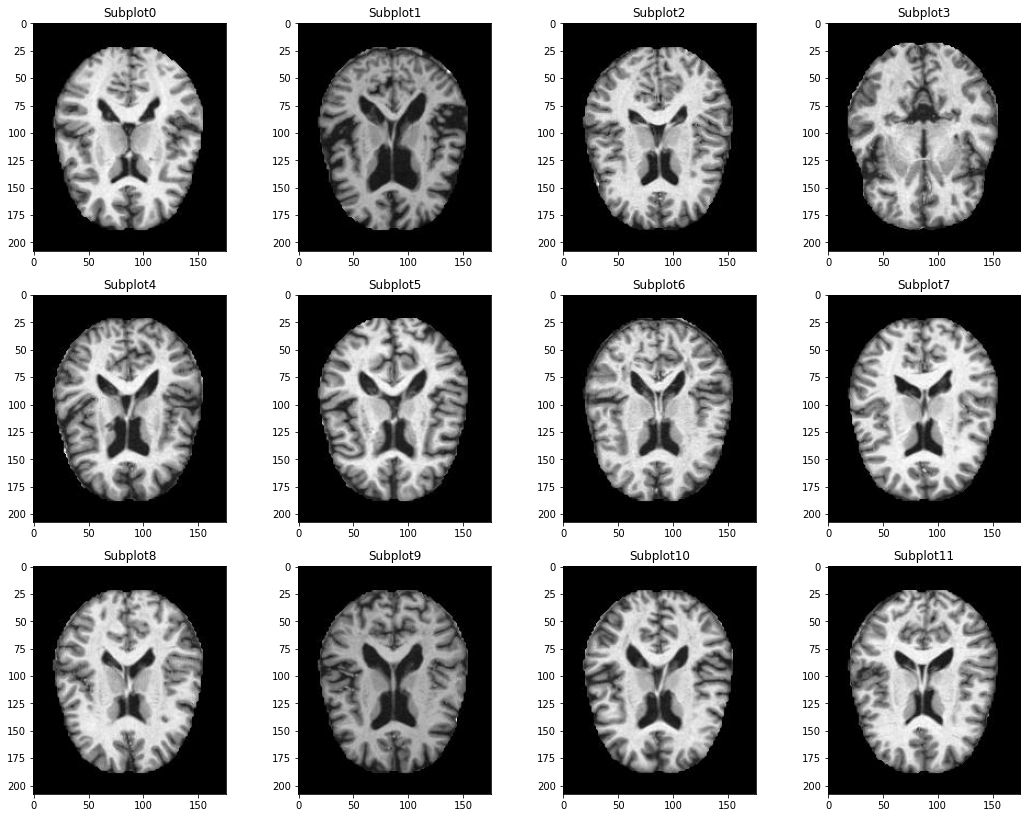

In [15]:
#visualization of couple brains
cols= 4
rows = 4
axes = []
width = 1000
height = 1000

fig = plt.figure(figsize=(15, 15))

for a in range(0,12):
    b = train_images[a].astype('uint8')
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b,cmap="gray")
fig.tight_layout()
plt.show()

In [16]:
'''#plt.histo(train_images[0].shape)
#hist = cv2.calcHist([train_images[0]],[0],None,[256],[0,256]) pixels = (pixels - mean) / std
testimage = test_images[0]
norm = (testimage - np.mean(testimage)) / np.std(testimage)
plt.hist(norm.ravel(),256,[-3,3])
plt.ylim(0,1000)

#plt.show()
plt.imshow(testimage)
np.std(norm)'''

'#plt.histo(train_images[0].shape)\n#hist = cv2.calcHist([train_images[0]],[0],None,[256],[0,256]) pixels = (pixels - mean) / std\ntestimage = test_images[0]\nnorm = (testimage - np.mean(testimage)) / np.std(testimage)\nplt.hist(norm.ravel(),256,[-3,3])\nplt.ylim(0,1000)\n\n#plt.show()\nplt.imshow(testimage)\nnp.std(norm)'

In [17]:
#iniziating model architecture
model = models.Sequential()
model.add(layers.Conv2D(50, (3, 3), activation='relu', input_shape=(208, 176, 1)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [18]:
#add dense layes to conv layers
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(4, activation="softmax"))


In [19]:
#model.summary()

In [20]:
EPOCHS = 40
BATCH_SIZE = 20
STEPS_PER_EPOCH = len(train_images)*0.6 // BATCH_SIZE

val_set = val_set.batch(BATCH_SIZE)


In [21]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.0001,
    decay_steps=STEPS_PER_EPOCH*100,
    decay_rate=1,
    staircase=False)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')


In [22]:
#compiling the model architecture and start fit
keras.backend.clear_session()
model.compile(optimizer=optimizer,
              loss="CategoricalCrossentropy",
              #loss="binary_crossentropy",
              metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])

with tf.device("/gpu:0"):
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        shuffle=True,
                        validation_data=val_set)
                    

Epoch 1/40
102/102 [==============================] - 13s 41ms/step - loss: 1.3231 - accuracy: 0.4270 - precision: 0.4342 - recall: 0.2201 - auc: 0.7270 - val_loss: 1.3422 - val_accuracy: 0.4493 - val_precision: 0.7500 - val_recall: 0.0106 - val_auc: 0.6340
Epoch 2/40
102/102 [==============================] - 3s 32ms/step - loss: 1.0562 - accuracy: 0.4884 - precision: 0.5602 - recall: 0.2575 - auc: 0.7908 - val_loss: 1.2957 - val_accuracy: 0.4116 - val_precision: 0.6497 - val_recall: 0.1356 - val_auc: 0.6612
Epoch 3/40
102/102 [==============================] - 3s 29ms/step - loss: 0.9738 - accuracy: 0.5446 - precision: 0.5886 - recall: 0.3745 - auc: 0.8213 - val_loss: 1.3599 - val_accuracy: 0.3042 - val_precision: 0.4751 - val_recall: 0.1910 - val_auc: 0.6371
Epoch 4/40
102/102 [==============================] - 3s 29ms/step - loss: 0.9756 - accuracy: 0.5433 - precision: 0.6155 - recall: 0.3925 - auc: 0.8234 - val_loss: 1.3783 - val_accuracy: 0.2866 - val_precision: 0.4619 - val_reca

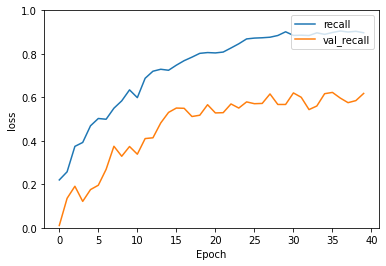

27/27 - 1s - loss: 1.5705 - accuracy: 0.6203 - precision: 0.6313 - recall: 0.6179 - auc: 0.8405 - 945ms/epoch - 35ms/step


In [23]:
#print val vs accuracy

plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.show()


test_loss, test_acc, test_prec, test_rec, test_auc  = model.evaluate(X_val, y_val, verbose=2)

In [170]:
y_pred = model.predict(X_train)


107/107 [==============================] - 1s 14ms/step


In [172]:
y_pred = np.argmax(y_pred,axis=-1)

y_train2 = y_train.copy()
y_train2 = np.argmax(y_train2, axis=-1)




array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [161]:
y_pred = [np.argmax(y_pred[x,:]) for x in range(len(y_pred))]

TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x000001C74B196DF0>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

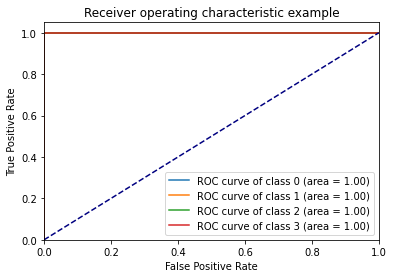

In [27]:
plt.figure()
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [ ]:
cc# get specific layer output - TAKES some time. Layer 7 is the output layer
with tf.device("/cpu:0"):
    get_layer_output = K.function([model.layers[0].input],
                                  [model.layers[9].output])
layer_output = get_layer_output([X_train])[0]

In [ ]:
for i in layer_output:
    #if np.argmax(i) != 0:
    print(np.argmax(i))

In [ ]:
#!mkdir -p saved_model2
#model.save("saved_model/model2")